# Ensemble methods

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Load data from file

In [2]:
df = pd.read_csv('wbc.csv', index_col='id')
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Split data into training and testing set

In [3]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

## Voting classifier
- different algorithms
- trained on the same (whole) data set

### Create multiple classifiers

In [4]:
logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
classifiers = [
    ('Logistic Regression', logreg),
    ('K Nearest Neighbors', knn),
    ('Classification Tree', dt)
]

### Fit each classifier

In [5]:
from sklearn.ensemble import VotingClassifier

for clf_name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))

Logistic Regression : 0.942
K Nearest Neighbors : 0.930
Classification Tree : 0.901


### Creating voting classifier

In [6]:
vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
print('Accuracy of Voting Classifier: {:.3f}'.format(accuracy_score(y_test, y_pred)))

Accuracy of Voting Classifier: 0.947


Voting classifiers outperforms each individual classifier

## Bagging classifier
- bootstrap aggregation (draw samples with replacement)
- only uses one algorithm (base estimator)
- each base estimator is trained on different subsets of the data

### Instantiate classifier

In [7]:
from sklearn.ensemble import BaggingClassifier

dt = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=0.16,
    random_state=42
)

### Create bagging classifier

In [8]:
bc = BaggingClassifier(
    base_estimator=dt,
    n_estimators=300,
    n_jobs=-1  # use all cpu cores
)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy_score(y_test, y_pred)))

Accuracy of Bagging Classifier: 0.906


Bagging classifier outperforms the individual classifier

### Validation using oob score
- Not each data point of training set is used in each bag (due to bootstrap)
- not used data points can be used to calculate the evaluation of the corresponging bag
- the scores of all bags are averaged and result in oob score

In [10]:
bc = BaggingClassifier(
    base_estimator=dt,
    n_estimators=300,
    n_jobs=-1,  # use all cpu cores
    oob_score=True    
)
bc.fit(X_train, y_train)
print('OOB Validation Accuracy of Bagging Classifier: {:.3f}'.format(bc.oob_score_))

OOB Validation Accuracy of Bagging Classifier: 0.925


## Random forest
- base estimator is a decision tree
- each estimator (random tree) is trained on a different bootstrap sample
- at each node only d features are sampled (without replacement)
- random forest collects prediction of each random tree and aggregates final output

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=0.16,
    random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Accuracy of Random forest Classifier: {:.3f}'.format(accuracy_score(y_test, y_pred)))

Accuracy of Random forest Classifier: 0.912


### Feature importance
- how much the tree nodes use a particular feature (weighted average) to reduce impurity

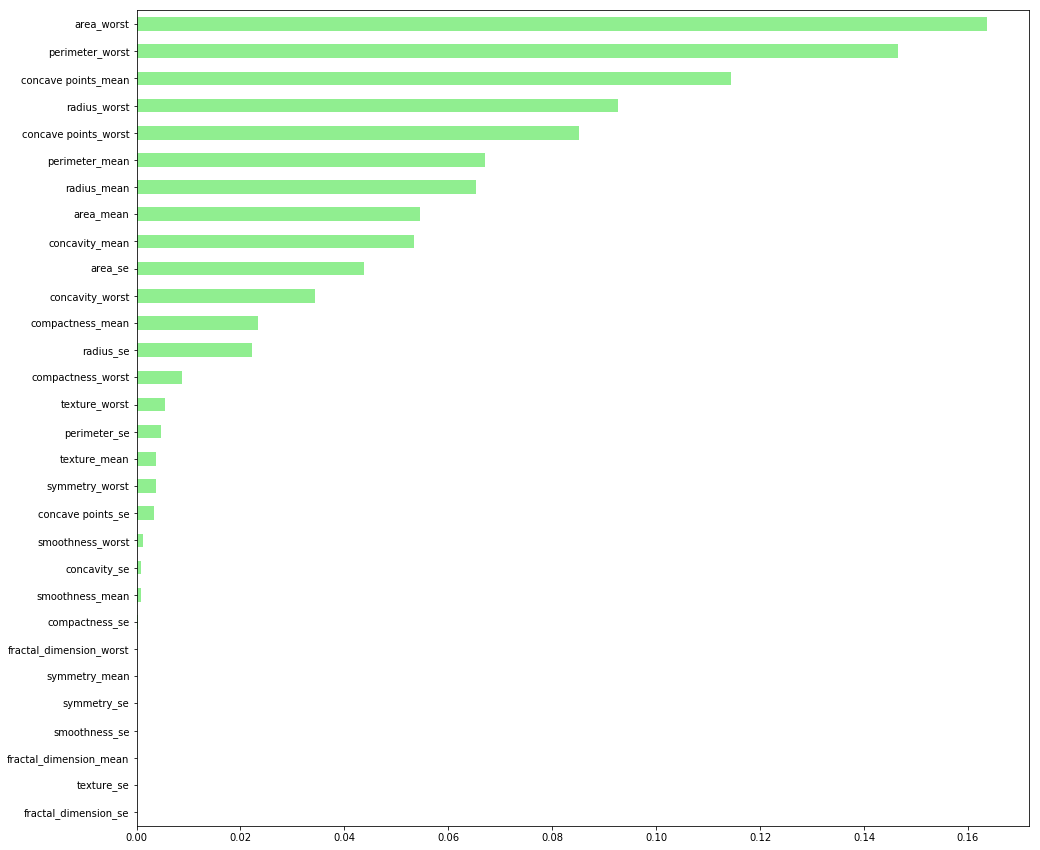

In [24]:
import matplotlib.pyplot as plt

importance = pd.Series(
    rf.feature_importances_,
    index = X.columns
).sort_values()

# plot result
importance.plot(
    kind='barh',
    color='lightgreen',
    figsize=(16, 15))
plt.show()